In [1]:
from src.utils.data_loader import LoadDataSet
from src.positioning.toa import toa_positioning
from itertools import permutations
from src.utils.models import DenseNet
from torchsummary import summary
import matplotlib.pyplot as plt
import scipy.io as sio
import numpy as np
import torch
import os

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
dir_name = "Omni Spatial and Temporal Data/"
min_delay_dataset = LoadDataSet(dir_name)
# all_paths_dataset = LoadDataSet(dir_name, path_mode="all_paths")
train_set, test_set = min_delay_dataset.get_datasets(scale=True)
train_dl = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_set, batch_size=1024, shuffle=False)

data_dir = os.path.abspath("../../"+dir_name)
toa_tensor_def = sio.loadmat(os.path.join(data_dir, "all_toa_tensor"))['toa_tensor']

bool_m = toa_tensor_def == min_delay_dataset.toa_tensor_compare
print(np.all(bool_m))  # sanity check that the data corresponding to the min_toa path is selected correctly

The shape of the feature data is (150000, 4, 6)
The shape of the target data is: (150000, 3)
The shape of the training data is: (75000, 4, 6)
The shape of the testing data is: (75000, 4, 6)
new training shape: (75000, 24)
True


In [3]:
in_dim = min_delay_dataset.input_shape
out_dim = min_delay_dataset.output_shape
layers_dim = [in_dim, in_dim*2, in_dim*2, in_dim*2, out_dim]
dnn_model = DenseNet(layers_dim)
dnn_model.to(device)
summary(dnn_model, input_data=(1,in_dim), device=device, depth=len(layers_dim))

Loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(dnn_model.parameters(), amsgrad=True)

Layer (type:depth-idx)                   Output Shape              Param #
├─ModuleList: 1                          []                        --
|    └─Linear: 2-1                       [-1, 1, 48]               1,200
|    └─Linear: 2-2                       [-1, 1, 48]               2,352
|    └─Linear: 2-3                       [-1, 1, 48]               2,352
|    └─Linear: 2-4                       [-1, 1, 3]                147
Total params: 6,051
Trainable params: 6,051
Non-trainable params: 0
Total mult-adds (M): 0.01
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.02
Estimated Total Size (MB): 0.02


In [4]:
def train_model(model=None, n_epochs=200):
    # train the model
    train_loss_history = []
    test_loss_history = []

    for epoch in range(n_epochs):
        total_train_loss = 0
        total_test_loss = 0
        total_train = 0
        total_test = 0

        # training loop (iterate over the training set)
        for x, y in train_dl:
            x_train, y_train = x.float().to(device), y.float().to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            train_output = model(x_train) # network output
            loss = Loss(train_output, y_train) # compute loss
            loss.backward() # compute gradient with respect to trainable parameters
            optimizer.step() # weights update
            total_train_loss += loss.item()
            total_train += 1

        print(f"Training at epoch: {epoch+1} ended, Loss: {total_train_loss/total_train}")
        # append training loss for the epoch
        train_loss_history.append(total_train_loss/total_train)

        # testing every 10 training epochs
        if ((epoch+1) % 10) == 0:
            for x, y in test_dl:
                x_test, y_test = x.float().to(device), y.float().to(device)
                test_output = model(x_test)
                loss = Loss(test_output, y_test)
                total_test_loss += loss.item()
                total_test += 1
            print(f"--> Testing at epoch: {epoch+1} ended, Loss: {total_test_loss/total_test}")
            # append test loss for the epoch
            test_loss_history.append(total_test_loss/total_test)

    print('Finished Training')
    return train_loss_history, test_loss_history

In [5]:
epochs = 300
train_model(model=dnn_model, n_epochs=epochs)
# torch.save(dnn_model.state_dict(), "./dnn_model")

Training at epoch: 1 ended, Loss: 16125.149504886145
Training at epoch: 2 ended, Loss: 15394.829813361575
Training at epoch: 3 ended, Loss: 15392.447618504026
Training at epoch: 4 ended, Loss: 15390.537656608296
Training at epoch: 5 ended, Loss: 1674.1146171686999
Training at epoch: 6 ended, Loss: 61.24623616482211
Training at epoch: 7 ended, Loss: 12.558172684378999
Training at epoch: 8 ended, Loss: 9.44730848226531
Training at epoch: 9 ended, Loss: 7.745268281155072
Training at epoch: 10 ended, Loss: 6.7397402928245755
--> Testing at epoch: 10 ended, Loss: 6.64587564081759
Training at epoch: 11 ended, Loss: 5.990795788809708
Training at epoch: 12 ended, Loss: 5.493528345745985
Training at epoch: 13 ended, Loss: 5.057424100948682
Training at epoch: 14 ended, Loss: 4.725691871100929
Training at epoch: 15 ended, Loss: 4.448604204091196
Training at epoch: 16 ended, Loss: 4.189199185920657
Training at epoch: 17 ended, Loss: 3.9949766536316367
Training at epoch: 18 ended, Loss: 3.803925157

In [6]:
'''layers_dim = [in_dim, in_dim*2, in_dim*2, in_dim*2, out_dim]
dnn_model = DenseNet(layers_dim)
dnn_model.to(device)
dnn_model.load_state_dict(torch.load("./dnn_model"))

# train for another 100 epochs
epochs = 100
train_model(n_epochs=epochs)
torch.save(dnn_model.state_dict(), "./dnn_model")'''

In [7]:
in_dim = min_delay_dataset.input_shape
out_dim = min_delay_dataset.output_shape
layers_dim = [in_dim, in_dim*2, in_dim*2, in_dim*2, out_dim]
dnn_model = DenseNet(layers_dim)
dnn_model.to(device)
dnn_model.load_state_dict(torch.load("./dnn_model"))

# evaluate the model over the entire data and the test data
train_error = []
test_error = []

for xx, yy in train_dl:
    x_to_pred, y_true = xx.float().to(device), yy.float().to(device)
    pred = dnn_model(x_to_pred)
    error = torch.sqrt(torch.sum((y_true - pred)**2, dim=1)).to("cpu").detach().numpy()
    #print(error.shape)
    train_error.extend(error)

for xx, yy in test_dl:
    x_to_pred, y_true = xx.float().to(device), yy.float().to(device)
    pred = dnn_model(x_to_pred)
    error = torch.sqrt(torch.sum((y_true - pred)**2, dim=1)).to("cpu").detach().numpy()
    # all_error.extend(error)
    test_error.extend(error)

train_error = np.array(train_error)
test_error = np.array(test_error)

The shape of the feature data is (150000, 4, 25, 6)
The shape of the target data is: (150000, 3)
The shape of the training data is: (75000, 4, 25, 6)
The shape of the testing data is: (75000, 4, 25, 6)
new training shape: (75000, 600)


In [8]:
# compute baseline results
toa_tensor = sio.loadmat(os.path.join(data_dir, "all_toa_tensor"))['toa_tensor']
zenith_aoa_tensor = sio.loadmat(os.path.join(data_dir, "all_zenith_tensor"))['zenith_aoa_tensor']
tot_points = toa_tensor.shape[0]*toa_tensor.shape[1]
toa_tensor_r = np.reshape(toa_tensor, (tot_points, toa_tensor.shape[2]))
true_cord_tensor_r = min_delay_dataset.y
zenith_aoa_tensor_r = np.reshape(zenith_aoa_tensor, (tot_points, zenith_aoa_tensor.shape[2]))
bss_coords = min_delay_dataset.bss_coords
# let's estimate the 3D UAV location for all the samples in the 50 trajectories
bs_idxs = range(4)
permutations(bs_idxs, 3)
perm = list(permutations(bs_idxs, 3))

best_est_3d_coords = np.zeros((tot_points, 3))
idx_best_found = np.zeros((tot_points, 1))

for i, data_tuple in enumerate(zip(toa_tensor_r, zenith_aoa_tensor_r)):
    toa_array, zenith_array = data_tuple
    # convert degrees to radians
    zenith_array = zenith_array*np.pi/180.0
    k = 0
    pos_found = False
    est_3d_pos = None
    prev_est_3d_pos = [0,0,0]
    final_est_3d_pos = None
    prev_error = np.inf
    while k < len(perm):
        bs1_idx, bs2_idx, bs3_idx = perm[k]
        pos_found, est_3d_pos = toa_positioning(bss_coords[[bs1_idx,bs2_idx,bs3_idx],:],
                                 toa_array[[bs1_idx,bs2_idx,bs3_idx]],
                                 zenith_array[[bs1_idx,bs2_idx,bs3_idx]])
        if k > 1 and pos_found:
            est_3d_pos = np.array(est_3d_pos)
            prev_est_3d_pos = np.array(prev_est_3d_pos)
            error = np.sqrt(np.sum((est_3d_pos-prev_est_3d_pos)**2))
            if error < prev_error:
                prev_error = error
                best_est_3d_coords[i,:] = est_3d_pos
                prev_est_3d_pos = est_3d_pos
                idx_best_found[i] = int(pos_found)

        k += 1

print(f"Total positions not found={tot_points - np.sum(idx_best_found)}")

Layer (type:depth-idx)                   Output Shape              Param #
├─ModuleList: 1                          []                        --
|    └─Linear: 2-1                       [-1, 1, 256]              153,856
|    └─Linear: 2-2                       [-1, 1, 64]               16,448
|    └─Linear: 2-3                       [-1, 1, 3]                195
Total params: 170,499
Trainable params: 170,499
Non-trainable params: 0
Total mult-adds (M): 0.17
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.65
Estimated Total Size (MB): 0.66


In [9]:
baseline_error = np.sqrt(np.sum((true_cord_tensor_r - best_est_3d_coords)**2, axis=1))
plt.figure(figsize=(10,6), dpi=100)
plt.plot(np.sort(baseline_error), np.linspace(0,1,tot_points), linewidth=2, label="Baseline")
plt.plot(np.sort(train_error), np.linspace(0,1,len(train_error)), linewidth=2, label="DL train data")
plt.plot(np.sort(test_error), np.linspace(0,1,len(test_error)), linewidth=2, label="DL test data")
plt.xlim([-2,20])
plt.ylabel("CDF", fontsize=12)
plt.xlabel("Estimation Error [m]", fontsize=12)
plt.title("CDF of the position estimation error")
plt.grid()
plt.legend(loc="lower right")
plt.savefig("./baseline_vs_deepl_cdf.png")

Training at epoch: 1 ended, Loss: 861.5269959680863
Training at epoch: 2 ended, Loss: 42.23447626890176
Training at epoch: 3 ended, Loss: 22.626483354348778
Training at epoch: 4 ended, Loss: 15.15685180511084
Training at epoch: 5 ended, Loss: 11.327723375461208
Training at epoch: 6 ended, Loss: 8.946033321753298
Training at epoch: 7 ended, Loss: 7.213315229316214
Training at epoch: 8 ended, Loss: 5.795206388719253
Training at epoch: 9 ended, Loss: 4.974568951048542
Training at epoch: 10 ended, Loss: 4.213096991181374
--> Testing at epoch: 10 ended, Loss: 5.501584426776783
Training at epoch: 11 ended, Loss: 3.7016705075730236
Training at epoch: 12 ended, Loss: 3.2768721870645727
Training at epoch: 13 ended, Loss: 2.934398550374923
Training at epoch: 14 ended, Loss: 2.610553389752074
Training at epoch: 15 ended, Loss: 2.375506562813354
Training at epoch: 16 ended, Loss: 2.1824082871549364
Training at epoch: 17 ended, Loss: 1.9762642544538496
Training at epoch: 18 ended, Loss: 1.839256520

In [10]:
all_paths_dataset = LoadDataSet(dir_name, path_mode="all_paths")
train_set, test_set = all_paths_dataset.get_datasets(dnn=True, scale=False)
train_dl = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_set, batch_size=1024, shuffle=False)

In [11]:
in_dim = all_paths_dataset.input_shape
out_dim = all_paths_dataset.output_shape
layers_dim = [in_dim, 256, 64, out_dim]
dnn_model_all_paths = DenseNet(layers_dim)
dnn_model_all_paths.to(device)
summary(dnn_model_all_paths, input_data=(1,in_dim), device=device, depth=len(layers_dim))

Loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(dnn_model_all_paths.parameters(), lr=5e-5, amsgrad=False)

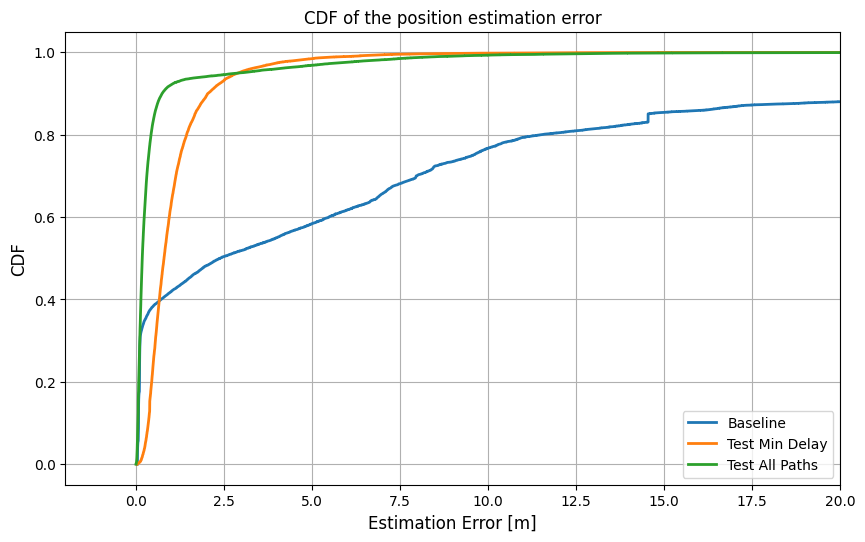

In [12]:
# train the model
train_loss_history = []
test_loss_history = []

for epoch in range(300):
    total_train_loss = 0
    total_test_loss = 0
    total_train = 0
    total_test = 0

    # training loop (iterate over the training set)
    for x, y in train_dl:
        x_train, y_train = x.float().to(device), y.float().to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        train_output = dnn_model_all_paths(x_train) # network output
        loss = Loss(train_output, y_train) # compute loss
        loss.backward() # compute gradient with respect to trainable parameters
        optimizer.step() # weights update
        total_train_loss += loss.item()
        total_train += 1

    print(f"Training at epoch: {epoch+1} ended, Loss: {total_train_loss/total_train}")
    # append training loss for the epoch
    train_loss_history.append(total_train_loss/total_train)

    # testing every 10 training epochs
    if ((epoch+1) % 10) == 0:
        for x, y in test_dl:
            x_test, y_test = x.float().to(device), y.float().to(device)
            test_output = dnn_model_all_paths(x_test)
            loss = Loss(test_output, y_test)
            total_test_loss += loss.item()
            total_test += 1
        print(f"--> Testing at epoch: {epoch+1} ended, Loss: {total_test_loss/total_test}")
        # append test loss for the epoch
        test_loss_history.append(total_test_loss/total_test)

print('Finished Training')

In [14]:
torch.save(dnn_model_all_paths.state_dict(), "./dnn_model_all_paths")

#### Testing the DNN with ALL Paths

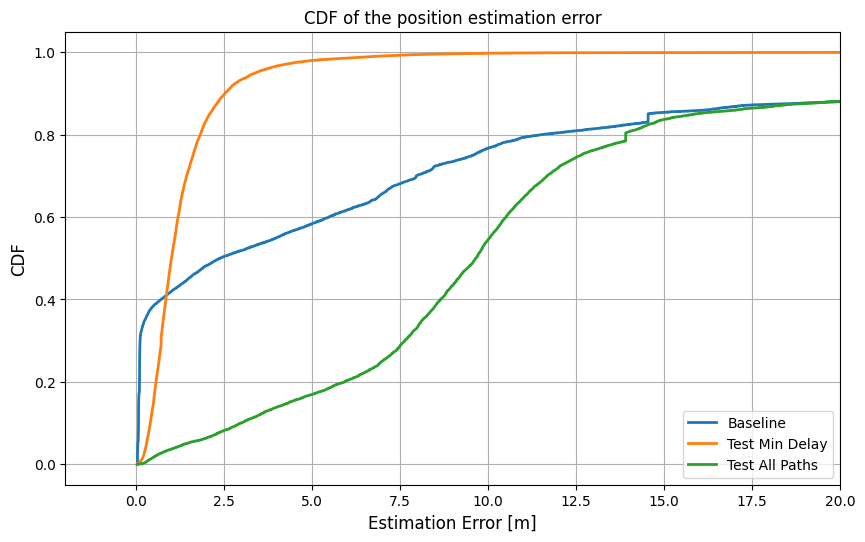

In [14]:
'''in_dim = all_paths_dataset.input_shape
out_dim = all_paths_dataset.output_shape
layers_dim = [in_dim, 256, 64, out_dim]
dnn_model_all_paths = DenseNet(layers_dim)
dnn_model_all_paths.to(device)
dnn_model_all_paths.load_state_dict(torch.load("./dnn_model_all_paths"))'''

# evaluate the model over the entire data and the test data
train_error_all_paths = []
test_error_all_paths = []
all_error_all_paths = []

for xx, yy in train_dl:
    x_to_pred, y_true = xx.float().to(device), yy.float().to(device)
    pred = dnn_model_all_paths(x_to_pred)
    error = torch.sqrt(torch.sum((y_true - pred)**2, dim=1)).to("cpu").detach().numpy()
    train_error_all_paths.extend(error)
    all_error_all_paths.extend(error)

for xx, yy in test_dl:
    x_to_pred, y_true = xx.float().to(device), yy.float().to(device)
    pred = dnn_model_all_paths(x_to_pred)
    error = torch.sqrt(torch.sum((y_true - pred)**2, dim=1)).to("cpu").detach().numpy()
    all_error_all_paths.extend(error)
    test_error_all_paths.extend(error)

train_error_all_paths = np.array(train_error_all_paths)
test_error_all_paths = np.array(test_error_all_paths)
all_error_all_paths = np.array(all_error_all_paths)

In [19]:
print(test_error_all_paths)

[0.07308568 0.04903797 0.6910957  ... 4.359654   0.39716312 0.5997959 ]


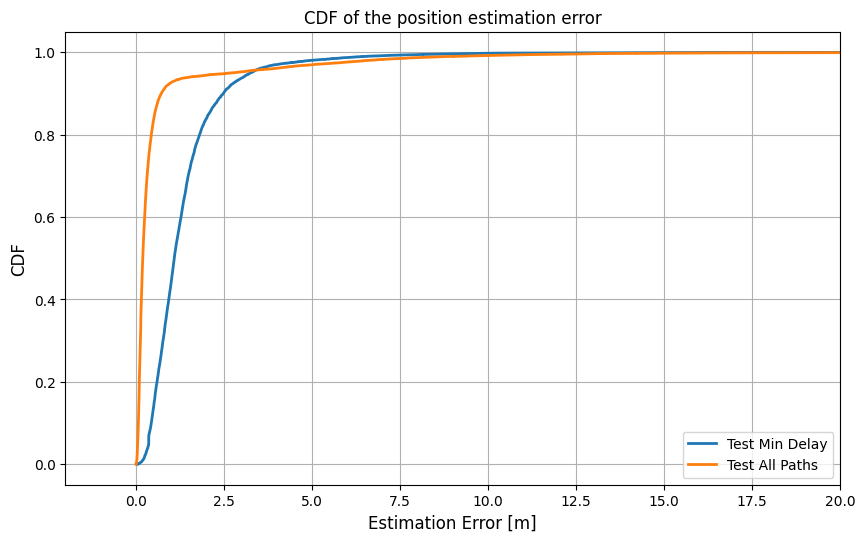

In [20]:
plt.figure(figsize=(10,6), dpi=100)
# plt.plot(np.sort(baseline_error), np.linspace(0,1,tot_points), linewidth=2, label="Baseline")
plt.plot(np.sort(test_error), np.linspace(0,1,len(test_error)), linewidth=2, label="Test Min Delay")
plt.plot(np.sort(test_error_all_paths), np.linspace(0,1,len(test_error_all_paths)), linewidth=2, label="Test All Paths")
plt.xlim([-2,20])
plt.ylabel("CDF", fontsize=12)
plt.xlabel("Estimation Error [m]", fontsize=12)
plt.title("CDF of the position estimation error")
plt.grid()
plt.legend(loc="lower right")
# plt.savefig("./baseline_vs_deepl_cdf.png")